## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.rand(4, 3)
y = torch.rand(3, 4)

print(x)
print(y)

tensor([[0.7316, 0.4791, 0.4084],
        [0.3505, 0.3503, 0.9881],
        [0.2063, 0.1912, 0.1311],
        [0.2882, 0.4137, 0.5749]])
tensor([[0.3909, 0.5986, 0.9000, 0.0765],
        [0.8322, 0.9537, 0.3066, 0.5965],
        [0.0454, 0.8208, 0.5003, 0.1310]])


**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [ ]:
c = torch.empty(4, 4)

print(torch.matmul(x, y, out = c))


tensor([[0.7033, 1.2300, 1.0097, 0.3953],
        [0.4734, 1.3549, 0.9173, 0.3652],
        [0.2457, 0.4134, 0.3098, 0.1470],
        [0.4831, 1.0389, 0.6738, 0.3441]])


**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
# вернем 0 для отрицательных значений и сами значения для положительных
def relu_forward(x):
    a = torch.zeros_like(x) 
    b = x*(x > 0)
    return torch.add(a, b)
    pass
    
assert torch.all(F.relu(x) == relu_forward(x))

In [ ]:
print(relu_forward(x))

tensor([[0.7316, 0.4791, 0.4084],
        [0.3505, 0.3503, 0.9881],
        [0.2063, 0.1912, 0.1311],
        [0.2882, 0.4137, 0.5749]])


**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
# зададим параметр alpha вручную
def elu_forward(x):
    alpha = float(input())
    a = torch.zeros_like(x)
    b = x*(x > 0)
    return b + torch.min(a, alpha*(torch.exp(x) - 1))
    pass

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 1e-4
    )

0.1


**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):
    a = torch.zeros_like(x)
    b = x*(x > 0)
    return b + torch.min(a, alpha*x)
    pass

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    return x*torch.tanh(torch.log(1 + torch.exp(x)))
    pass

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    return x*torch.sigmoid(x)
    pass

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [ ]:
?torch.optim.Adam

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr = 0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        for param in filter(lambda x: x.grad is not None, group['params']):
          self._init_adam_buffer(param)
          state = self.state[param]
          g = param.grad

          m, v, t = self._get_adam_buffer(param)
          #v = self._get_adam_buffer(param)
          #t = self._get_adam_buffer(param)

          state['m'] = beta_1*m + (1-beta_1)*g
          state['v'] = beta_2*v + (1-beta_2)*(g**2)
          mt = m/ (1-beta_1**t)
          vt = v / (1-beta_2**t)
          param -= (lr*mt)/(torch.sqrt(vt + eps))
          state['t'] += 1

          pass
    
    
    def _get_adam_buffer(self, param):

        state = self.state[param]

        return state['m'], state['v'], state['t']

        """
        Get accumulated gradients for Adam.
        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.
        Returns
        -------
        Accumulated Adam gradients for parameter.
        """

        pass

        #делаем массив с аккумулированными градиентами

    def _init_adam_buffer(self, param):

      state = self.state[param]
     
      if 'm' not in state:
          state['m'] = torch.zeros_like(param)
      if 'v' not in state:
          state['v'] = torch.zeros_like(param)
      if 't' not in state:
          state['t'] = 1

In [ ]:
# запустим модель, чтобы сравнить наш Adam с официальным оптимайзером

from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

In [ ]:
def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())

In [ ]:
model = get_model()
optim = Adam(model.parameters(), lr = 0.001)
check_optimizer(model, optim, num_iter=1000)


Iteration 0 loss: 7319.2880859375
Iteration 100 loss: 7229.4619140625
Iteration 200 loss: 7084.46728515625
Iteration 300 loss: 6849.0966796875
Iteration 400 loss: 6525.591796875
Iteration 500 loss: 6129.91064453125
Iteration 600 loss: 5686.94482421875
Iteration 700 loss: 5219.1298828125
Iteration 800 loss: 4742.00537109375
Iteration 900 loss: 4265.69580078125


In [ ]:
# Сравним с официальным оптимизатором:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 7319.2880859375
Iteration 100 loss: 7228.451171875
Iteration 200 loss: 7082.50146484375
Iteration 300 loss: 6846.60302734375
Iteration 400 loss: 6523.00830078125
Iteration 500 loss: 6127.716796875
Iteration 600 loss: 5685.51123046875
Iteration 700 loss: 5218.5517578125
Iteration 800 loss: 4742.22265625
Iteration 900 loss: 4266.6083984375


**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [ ]:
import math

In [ ]:
# n_in = 28**2 = 784, т.к. n должно быть равно числу входов, т.е. размерности картинки
# n_out = 10 (классов, в MNIST датасете)

sd = math.sqrt(6/(784+10))
weights = torch.tensor(np.random.uniform(-sd, sd, size = (10, 784)), requires_grad = True)
intercept = torch.tensor(np.random.uniform(-sd, sd, size = (1,10)), requires_grad = True)

print(weights.size())
print(intercept.size())
# размерность вектора весов - 1 * 784, т.е. для каждого пикселя на изображении, + 10 выходных классов

torch.Size([10, 784])
torch.Size([1, 10])


Загрузим данные и создадим даталоадеры:

In [ ]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(fashion_mnist_train, batch_size = 16, shuffle=True, num_workers=1)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
eval_dataloader = DataLoader(fashion_mnist_eval, batch_size = 16, shuffle=True, num_workers=1)

classes = ('1', '2', '3', '4',
           '5', '6', '7', '8', '9', '10')

In [ ]:
for i in train_dataloader:
  break
print(i[0].shape)
print(i[1])
# 16 - число изображений в батче

torch.Size([16, 1, 28, 28])
tensor([9, 3, 9, 4, 2, 0, 4, 9, 4, 0, 3, 1, 1, 9, 4, 7])


In [ ]:
fashion_mnist_train[12][0].shape
# Мы видим, что у нас одноканальные изображения 28*28

torch.Size([1, 28, 28])

In [ ]:
fashion_mnist_train[12][1] # ему соответствует класс 5

5


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
for batch in train_dataloader:
  images, labels = batch
  images = images.view(-1, 28 * 28) # переведем картинку в вектор

print(images.shape)
print(labels.shape)

torch.Size([16, 784])
torch.Size([16])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# инициируем модель, которую затем будем использовать

criterion = nn.CrossEntropyLoss()

optimizer = Adam([weights, intercept])

# weights и intercept мы задали ранее при помощи Xavier-инициализации

# 1) predictions
#2) loss
#3) gradients
#4) optimization step
#5) обнуляем grads
#6) metrics
#7) return metrics

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds))


class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        out = torch.sigmoid(self.linear(x))
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        outputs = self(images)   # 1) Предсказания
        loss = nn.CrossEntropyLoss()(outputs, labels) # 2) loss
        acc = accuracy(outputs, labels)
        return preds, loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)    
        loss = nn.CrossEntropyLoss()(out, labels)  
        acc = accuracy(out, labels)  
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [ ]:
model = LogisticRegression()

In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias: 
          torch.nn.init.xavier_uniform_(m.bias)

init_weights(model)

In [ ]:
list(model.parameters()) # выведем веса и bias

[Parameter containing:
 tensor([[-0.0128,  0.0325,  0.0095,  ..., -0.0059, -0.0002,  0.0239],
         [-0.0181, -0.0089,  0.0039,  ...,  0.0037, -0.0094, -0.0144],
         [-0.0256, -0.0283,  0.0129,  ...,  0.0337, -0.0168,  0.0221],
         ...,
         [ 0.0178, -0.0028,  0.0052,  ...,  0.0083, -0.0148,  0.0092],
         [-0.0117, -0.0032,  0.0026,  ...,  0.0092, -0.0256,  0.0328],
         [ 0.0175, -0.0018,  0.0315,  ..., -0.0249, -0.0060, -0.0282]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0234, -0.0124, -0.0063,  0.0283,  0.0075, -0.0281, -0.0185,  0.0077,
         -0.0352,  0.0217], requires_grad=True)]

In [ ]:
for images, labels in train_dataloader:
  outputs = model(images)
  break

print(outputs.shape) 
# применив модель к картинкам в одном батче, мы получаем 16 изображений * 10 классов, 
# для каждого из которых выдается отклик модели на изображение (предпологаем, что самые высокие значения говорят о том, что с большей 
# вероятностью изображение будет принадлежать к данному классу)
print(outputs[1].data)

torch.Size([16, 10])
tensor([0.5459, 0.5434, 0.4329, 0.4743, 0.6144, 0.4832, 0.4996, 0.5301, 0.5172,
        0.5435])


In [ ]:
probs = F.softmax(outputs, dim = 1) 
# избавляемся от неположительных значений
# используя отношение e^(значение)/сумма всех значений, мы находим вероятности принадлежности к каждому классу
print(probs[1].data)
print(torch.sum(probs[1]).item()) # проверяем, что сумма вероятностей = 1 

tensor([0.1027, 0.1024, 0.0917, 0.0956, 0.1099, 0.0964, 0.0980, 0.1011, 0.0998,
        0.1024])
0.9999999403953552


In [ ]:
# preds
max_probs, preds = torch.max(probs, dim = 1) # назначаем каждому изображению предсказание класса, у которого наибольшая вероятность
print(preds) # 16 предсказанных классов для батча

tensor([0, 4, 4, 0, 0, 0, 0, 4, 0, 7, 0, 9, 0, 7, 0, 0])


In [ ]:
def evaluate(model, eval_dataloader):
    outputs = [model.validation_step(batch) for batch in eval_dataloader]
    return model.validation_epoch_end(outputs) # 5) Считаем метрики


def fit(epochs, model, train_dataloader, eval_dataloader, opt_func = optimizer):
    
    optimizer = Adam(model.parameters())
    #epochs
    train_size = 0
    train_loss = 0
    train_acc = 0
    
    history = []

    accuracies = []
    losses = []
    train_losses = []
    train_accs = []

    for epoch in range(epochs): 
        for batch in train_dataloader:
            optimizer.zero_grad() # 3) Обнуляем градиенты
            out, loss, acc = model.training_step(batch)
            train_losses.append(loss.item())
            train_accs.append(acc)
            loss.backward()
            optimizer.step() # 4) Optimization step
            
        result = evaluate(model, eval_dataloader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history, train_losses, train_accs

In [ ]:
# посмотрим на то, как растет качество модели в ходе спуска
history_1, losses_1 , accuracy_1 = fit(30, model, train_dataloader, eval_dataloader)

Epoch [0], val_loss: 1.6249, val_acc: 0.7726
Epoch [1], val_loss: 1.6068, val_acc: 0.8084
Epoch [2], val_loss: 1.5993, val_acc: 0.8181
Epoch [3], val_loss: 1.5945, val_acc: 0.8251
Epoch [4], val_loss: 1.5925, val_acc: 0.8238
Epoch [5], val_loss: 1.5897, val_acc: 0.8253
Epoch [6], val_loss: 1.5892, val_acc: 0.8310
Epoch [7], val_loss: 1.5871, val_acc: 0.8296
Epoch [8], val_loss: 1.5863, val_acc: 0.8299
Epoch [9], val_loss: 1.5851, val_acc: 0.8300
Epoch [10], val_loss: 1.5846, val_acc: 0.8340
Epoch [11], val_loss: 1.5838, val_acc: 0.8321
Epoch [12], val_loss: 1.5845, val_acc: 0.8316
Epoch [13], val_loss: 1.5827, val_acc: 0.8339
Epoch [14], val_loss: 1.5828, val_acc: 0.8337
Epoch [15], val_loss: 1.5820, val_acc: 0.8346
Epoch [16], val_loss: 1.5808, val_acc: 0.8352
Epoch [17], val_loss: 1.5808, val_acc: 0.8329
Epoch [18], val_loss: 1.5819, val_acc: 0.8302
Epoch [19], val_loss: 1.5806, val_acc: 0.8364
Epoch [20], val_loss: 1.5824, val_acc: 0.8320
Epoch [21], val_loss: 1.5809, val_acc: 0.833

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

1) Изначально в формуле параметров **m** и **v** закладывается умножение градиента на разность 1 и некоторой величины *beta* - тем самым, определяется "вес" градиента в значении параметра, и, как мы можем увидеть, с каждой последующей итерацией он будет увеличиваться по мере того, как уменьшается *beta*, а значит, оптимизация будет медленной в начале (чтобы избежать сильного смещения, и чтобы у нас не возникло слишком быстрой сходимости), и более быстрой в конце. 

Когда мы изменяем m и v на скорректированные параметры **mt** и **vt**, мы закладываем несмещенность оценки - т.е. реальная величина нашего параметра равна математическому ожиданию. Мы знаем, что v равняется квадрату градиента, помноженному на сумму коэффициентов (*beta*) от i до t. Если мы попробуем вычислить матожидание **v**, то увидим, что оно будет равно 1-*beta_2*^t. Таким образом, при вычислении **vt**, мы делим на стандартное отклонение, что и позволяет получить несмещенные оценки. То же самое с mt. Иными словами, деление исходных параметров на (1 - *beta*) позволяет избежать bias-а на первых шагах оптимизации. 

2) Модель начинает переобучаться в момент между 10 и 15 шагами (epoch), и мы можем увидеть на двух последних графиках, что кривая начинает вести себя менее стабильно, что говорит о большой вариации. Мы также видим это в выдаче - после 11-13 эпох loss не всегда убывает за счет большей ошибки. Поэтому accuracy перестает расти.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='*', s=180, c='red', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

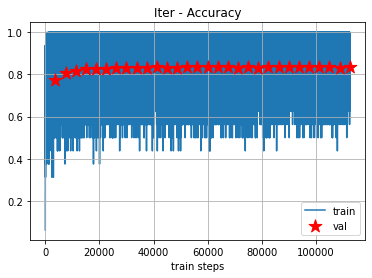

In [ ]:
accuracies = [result['val_acc'] for result in history_1]

plot_history(accuracy_1, accuracies, "Iter - Accuracy")

# простите, я не смогла отказаться от коммунистических звездочек


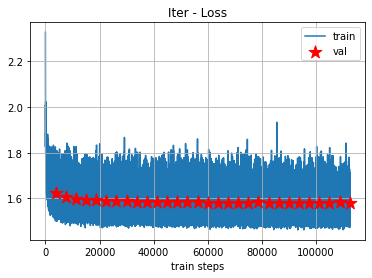

In [ ]:
loss = [result['val_loss'] for result in history_1]

plot_history(losses_1, loss, "Iter - Loss")

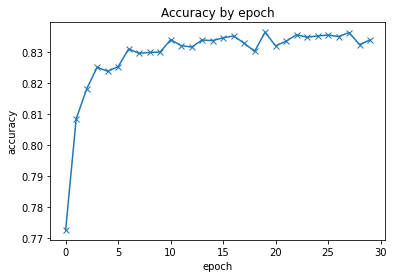

In [ ]:
accuracies = [result['val_acc'] for result in history_1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy by epoch');

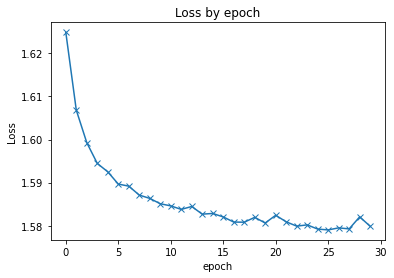

In [ ]:
accuracies = [result['val_loss'] for result in history_1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss by epoch');

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
class Accuracy:
    def __init__(self):
        self._all_predictions = torch.LongTensor()
        self._all_labels = torch.LongTensor()

    def __call__(self, predictions, labels):
        # predictions ~ (batch size)
        # labels ~ (batch size)
        self._all_predictions = torch.cat([
            self._all_predictions,
            predictions
        ], dim=0)
        self._all_labels = torch.cat([
            self._all_labels,
            labels
        ], dim=0)

    def get_metric(self, reset=False):
        correct = (self._all_predictions == self._all_labels).long()
        accuracy = correct.sum().float() / self._all_labels.size(0)
        if reset:
            self.reset()
        return accuracy

    def reset(self):
        self._all_predictions = torch.LongTensor()
        self._all_labels = torch.LongTensor()

In [ ]:
# В общем виде для сетей (encoder), Accuracy считаем одинаково
class ModelAssess(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self._encoder = encoder
        self._accuracy = Accuracy()

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._encoder(images)
        output_dict = {'logits': output, 'probs': torch.softmax(output, dim=-1)}
        output_dict['preds'] = torch.argmax(output_dict['probs'], dim=-1)
        if target is not None:
            # CrossEntropy Loss
            log_softmax = torch.log_softmax(output, dim=-1)
            output_dict['loss'] = F.nll_loss(log_softmax, target)
            self._accuracy(
                output_dict['preds'].cpu(),
                target.cpu()
            )
        return output_dict

    def decode(self, output_dict):
        # output_dict ~ dict with torch.Tensors (output_dict from forward)
        return [idx_to_label[int(x)] for x in output_dict['preds']]

    def get_metrics(self, reset=False):
        return {'accuracy': self._accuracy.get_metric(reset)}

In [ ]:
# (conv + relu + pool)*2 - residual net
class AsResNetEncoder(torch.nn.Module):
  def __init__(self, dropout=0.4):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)
        self.output = torch.nn.Linear(in_features=64, out_features=10)
        self.dropout = torch.nn.Dropout(p=dropout)
        # --------------

  def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        return self.output(x)

In [ ]:
model_resnet = AsResNetEncoder()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_resnet.to(device) # 2 сверточных слоя + 2 полносвязных

AsResNetEncoder(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=1600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
# VGG

# conv + ReLU
# max pooling
# FC + ReLU
# softmax

class VGGencoder(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        #self._input_batch_norm = torch.nn.BatchNorm2d(1) 
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.layer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer(x)
        return x

In [ ]:
model_vgg = VGGencoder()

In [ ]:
model_vgg.to(device)

VGGencoder(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (layer): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [ ]:
# только полносвязные слои

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self._output = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = x.view(-1, 16 * 5 * 5) # Растягиваем данные из тензора в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self._output(x)

model_fc = SimpleCNN()

In [ ]:
model_fc.to(device)

SimpleCNN(
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (_output): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    return_acc=False,
    device='cpu'
):
  model = model.train()
  total_loss = 0
  num_batches = 0
  total_acc=0
  all_acc=[]
  all_losses = []
  with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
      for batch in data_loader:
            # Move Batch to GPU
          batch = [x.to(device='cpu') for x in batch]
          output_dict = model(*batch)
          loss = output_dict['loss']
            # Update weights
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
            # Update descirption for tqdm
          metrics = model.get_metrics()
          prbar.set_description(
              f"Loss: {round(loss.item(), 4)} "
              f"Accuracy: {round(metrics['accuracy'].item(), 4)}"
          )
          prbar.update(1)
          total_acc += metrics['accuracy'].item()
          total_loss += loss.item()
          num_batches += 1
          all_losses.append(loss.detach().item())
          all_acc.append(metrics['accuracy'].detach().item())
  metrics = {'loss': total_loss / num_batches}
  metrics.update(model.get_metrics(reset=True))
  if return_losses:
    return metrics, all_losses, all_acc
  else:
    return metrics


In [ ]:
def validate(model, data_loader, device = 'cpu'):
    model = model.eval()
    total_loss = 0
    num_batches = 0

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device= 'cpu') for x in batch]
            output_dict = model(*batch)
            loss = output_dict['loss']
            metrics = model.get_metrics()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(metrics['accuracy'].item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            one_epoch_ac=metrics['accuracy'].detach().item()
    metrics = {'loss': total_loss / num_batches}
    metrics.update(model.get_metrics(reset=True))
    return metrics, one_epoch_ac

In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    device
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    all_train_acc=[]
    epoch_eval_acc=[]
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses, one_epoch_train_acc = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            device = device)
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        all_train_acc.extend(one_epoch_train_acc)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics,one_epoch_ac = validate(
                model=model,
                data_loader=validation_data_loader,
            )
        # Save eval losses
        epoch_eval_acc.append(one_epoch_ac)
        epoch_eval_losses.append(validation_metrics['loss'])
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses, all_train_acc,epoch_eval_acc)

In [ ]:
from collections import defaultdict

idx_to_label = defaultdict(lambda: 'All', {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
})

In [ ]:
from collections import namedtuple

LossInfo = namedtuple(
    'LossInfo', 
    ['full_train_losses', 'train_epoch_losses', 'eval_epoch_losses',"all_train_acc","epoch_eval_acc"]
)

In [ ]:
torch.cuda.is_available()

False

In [ ]:
# цикл обучения

model = ModelAssess(encoder = AsResNetEncoder()).to(device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.SGD(model.parameters(),momentum=0.9,lr=0.001),
    device = 'cpu')

# accuracy 0.57

Train Epoch: 0
Loss: 0.5588 Accuracy: 0.5922: 100%|██████████| 3750/3750 [01:33<00:00, 40.03it/s]
Validation Epoch: 0
Loss: 0.5517 Accuracy: 0.7522: 100%|██████████| 625/625 [00:08<00:00, 73.57it/s]
Train Epoch: 1
Loss: 0.5484 Accuracy: 0.7681: 100%|██████████| 3750/3750 [01:32<00:00, 40.34it/s]
Validation Epoch: 1
Loss: 0.4462 Accuracy: 0.8034: 100%|██████████| 625/625 [00:08<00:00, 71.69it/s]
Train Epoch: 2
Loss: 0.438 Accuracy: 0.8066: 100%|██████████| 3750/3750 [01:32<00:00, 40.33it/s]
Validation Epoch: 2
Loss: 0.2577 Accuracy: 0.8276: 100%|██████████| 625/625 [00:08<00:00, 73.10it/s]
Train Epoch: 3
Loss: 0.1109 Accuracy: 0.8301: 100%|██████████| 3750/3750 [01:33<00:00, 40.20it/s]
Validation Epoch: 3
Loss: 0.2521 Accuracy: 0.8349: 100%|██████████| 625/625 [00:08<00:00, 69.86it/s]
Train Epoch: 4
Loss: 0.2114 Accuracy: 0.8472: 100%|██████████| 3750/3750 [01:33<00:00, 40.27it/s]
Validation Epoch: 4
  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
model = ModelAssess(encoder = AsResNetEncoder()).to(device)
rmsprop_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(),momentum=0.9,lr=0.001),
    device = 'cpu')

# accuracy 0.8

Train Epoch: 0
Loss: 0.3919 Accuracy: 0.7687: 100%|██████████| 3750/3750 [01:40<00:00, 37.15it/s]
Validation Epoch: 0
Loss: 0.3518 Accuracy: 0.8064: 100%|██████████| 625/625 [00:08<00:00, 76.60it/s]
Train Epoch: 1
Loss: 0.2284 Accuracy: 0.7996: 100%|██████████| 3750/3750 [01:59<00:00, 31.47it/s]
Validation Epoch: 1
Loss: 0.7182 Accuracy: 0.8048: 100%|██████████| 625/625 [00:08<00:00, 77.16it/s]
Train Epoch: 2
Loss: 0.5297 Accuracy: 0.8012: 100%|██████████| 3750/3750 [02:25<00:00, 25.70it/s]
Validation Epoch: 2
Loss: 0.4987 Accuracy: 0.7979: 100%|██████████| 625/625 [00:09<00:00, 68.65it/s]
Train Epoch: 3
Loss: 0.1358 Accuracy: 0.7979: 100%|██████████| 3750/3750 [02:28<00:00, 25.18it/s]
Validation Epoch: 3
Loss: 0.4853 Accuracy: 0.8088: 100%|██████████| 625/625 [00:08<00:00, 69.95it/s]
Train Epoch: 4
Loss: 0.3363 Accuracy: 0.7932:  53%|█████▎    | 1980/3750 [01:18<01:09, 25.36it/s]


KeyboardInterrupt: ignored

In [ ]:
plot_history(sgd_momentum_loss_info.full_train_losses, sqd_momentum_loss_info.eval_epoch_losses, title='AsResNet loss, SGD Momentum')

NameError: ignored

In [ ]:
plot_history(rmsprop_loss_info.all_train_acc, rmsprop_loss_info.eval_epoch_losses, title='AsResNet accuracy, RMSprop')

In [ ]:
model = ModelAssess(encoder = VGGencoder()).to(device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.SGD(model.parameters(),momentum=0.9,lr=0.001),
)

In [ ]:
model = ModelAssess(encoder = VGGencoder()).to(device)
rmsprop_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(),momentum=0.9,lr=0.001),
)

In [ ]:
plot_history(sgd_momentum_loss_info.full_train_losses, sqd_momentum_loss_info.eval_epoch_losses, title='VGG loss, SGD Momentum')

In [ ]:
plot_history(rmsprop_loss_info.all_train_acc, rmsprop_loss_info.eval_epoch_losses, title='VGG accuracy, RMSprop')

In [ ]:
model = ModelAssess(encoder = SimpleCNN().to(device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.SGD(model.parameters(),momentum=0.9,lr=0.001),
)

In [ ]:
model = ModelAssess(encoder = SimpleCNN()).to(device)
rmsprop_loss_info = fit(
    model=model,
    epochs=50,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(),momentum=0.9,lr=0.001),
)

In [ ]:
plot_history(sgd_momentum_loss_info.full_train_losses, sqd_momentum_loss_info.eval_epoch_losses, title= 'SimpleCNN, SGD Momentum')

In [ ]:
plot_history(rmsprop_loss_info.all_train_acc, rmsprop_loss_info.eval_epoch_losses, title='SimpleCNN, RMSprop')

К сожалению, ресурсы моего ноутбука и интернет дома не позволяют оценить history для всех моделей, однако исходя из материала, переданного нам на лекциях, хуже всего метрики качества будут у модели, составляенной только из полносвязных слоев. Скорее всего, она будет сильно переобучаться, потому что состоит только из linear слоев, и не может зафиксировать нелинейность. 

Скорее всего, лучше всех качество будет у VGG, т.к. в ней dropout применяется не один раз в конце, а после каждого слоя - тем самым, те наблюдения, на которых модель уже обучилась, выбрасываются, и не происходит сильного переобучения.

Однако, в модели AsResNet больше слоев, и вероятно, по качеству она может быть близка к VGG. 